# Uber: Estimating Beta (SCL vs. Comparables)

#### Aidan Cremins, Peyton Lewis, Joe Morris, Amrit Sandhu

## Part I: SCL Analysis

### Necessary Imports

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import yfinance as yf

import warnings
warnings.filterwarnings('ignore')

### Assumptions

<li>Granularity: Weekly<br>
<li>Timeframe: Two years<br>
<li>Risk Free Rate: 0%

### Read in Data

In [2]:
uber_data = pd.read_csv('UBER.csv')

In [3]:
uber_data['Market Risk Premium'] = uber_data['Adj_Close_Market'].pct_change(1) - uber_data['rf_rate']
uber_data['Uber Risk Premium'] = uber_data['Adj_Close_Uber'].pct_change(1) - uber_data['rf_rate']
uber_data = uber_data.fillna(0)
uber_data

,Adj_Close_Uber,Adj_Close_Market,rf_rate,MRP,URP,Market Risk Premium,Uber Risk Premium
0,33.720001,337.360901,0,0.000000,0.000000,0.000000,0.000000
1,36.750000,335.894012,0,-0.004348,0.089858,-0.004348,0.089858
2,33.410000,317.204102,0,-0.055642,-0.090884,-0.055642,-0.090884
3,44.869999,340.148834,0,0.072334,0.343011,0.072334,0.343011
4,47.610001,347.861816,0,0.022675,0.061065,0.022675,0.061065
...,...,...,...,...,...,...,...
101,27.820000,367.950012,0,-0.041754,-0.128719,-0.041754,-0.128719
102,26.500000,357.179993,0,-0.029270,-0.047448,-0.029270,-0.047448
103,28.070000,362.790009,0,0.015706,0.059245,0.015706,0.059245
104,24.709999,357.630005,0,-0.014223,-0.119701,-0.014223,-0.119701


In [4]:
#define predictor and response variables
y = uber_data['Uber Risk Premium'].iloc[1:]
x = uber_data['Market Risk Premium'].iloc[1:]

#add constant to predictor variables
x = sm.add_constant(x)

#fit linear regression model
model = sm.OLS(y, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Uber Risk Premium   R-squared:                       0.268
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                     37.67
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           1.58e-08
Time:                        02:12:37   Log-Likelihood:                 130.63
No. Observations:                 105   AIC:                            -257.3
Df Residuals:                     103   BIC:                            -252.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -0.0008    

### Beta Analysis

In [5]:
uber_beta = model.params[1]
uber_tstat_0 = model.tvalues[1]
uber_se = model.bse[1]

To test whether the coeffient is statistically signicantly different from the market's Beta of 1, we run a Hypothesis Test with the null hypothesis that Uber's Beta is equal to 1.

In [6]:
uber_t_stat = (uber_beta - 1) / uber_se
uber_t_stat

2.3264399090637746

Because the relevant t statisitc is 2.326 and there are enough data points (n = 105) to assume that the Student T Distribution is well-approximated by the Normal curve, a critical t value of 1.96 is used. This indicates that Uber's Beta is statisically different from the market Beta of 1 and therefore carries more risk than a well diversified portfolio.

### Confidence Interval of Beta

In [7]:
lower_bound = uber_beta - 1.96 * uber_se
upper_bound = uber_beta + 1.96 * uber_se
print(lower_bound, upper_bound)

1.09614681721068 2.124679774848414


When computing the upper and lower bound on the Beta estimate for Uber using the critical t-value of 1.96, the bound is found to be (1.096, 2.125), which differs slightly from the OLS output, which interpolated the exact critical t-statistic using the sample size (instead of approximating with the Normal curve). This 95% confidence interval was computed by taking the product of the critical t-value of 1.96 and the standard error of the Beta estimate of 0.262 and adding and subtracting it from the Beta estimate of 1.610 (Confidence interval = Beta +- t_critical * standard error of Beta). The critical t value of 1.96 is used because in a normal distribution, 95% of the area under the curve is contained within 1.96 standard deviations on either side of the mean. This will allow us to obtain a 95% confidence interval on our Beta estimate for Uber. <br><br>
This interval, centered at the Beta estimate for Uber, indicates that if this process were repeated many times, 95% of the generated estimates for Uber's Beta would fall within this interval. This Beta was computed using weekly returns for two years. This level of granularity provides a sample size of 105 data points, which would lead to a much tighter interval around Beta than 2 years of monthly returns, for example. This is a function of the sample size, because as sample size increases, the standard error of the Beta estimate decreases, and its corresponding confidence interval will tighten as well.

### Security Characteristic Line

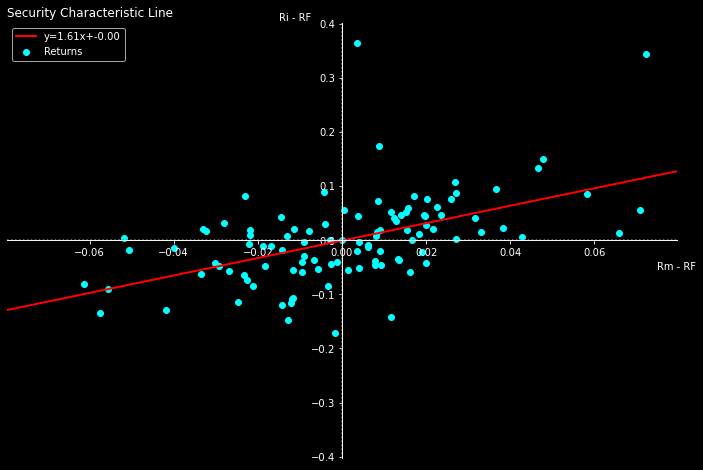

In [8]:
x = uber_data['Market Risk Premium']
y_actual = uber_data['Uber Risk Premium']
    
x_all = np.linspace(-4, 4, 100)
y = model.params['const'] + model.params['Market Risk Premium'] * x_all


x_range = max(abs(max(x)), abs(min(x))) + max(abs(max(x)), abs(min(x))) * .1
y_range = max(abs(max(y_actual)), abs(min(y_actual))) + max(abs(max(y_actual)), abs(min(y_actual))) * .1
max_range = max(x_range, y_range)

plt.style.use('dark_background')
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_position('zero')
ax.spines['top'].set_position('zero')
ax.yaxis.set_label_coords(.53, 1)
ax.xaxis.set_label_coords(1, .53)
plt.scatter(x=x, y=y_actual, label='Returns', color='cyan')
plt.plot(x_all, y, color='red', linewidth=2, \
    label='y={:.2f}x+{:.2f}'.format(model.params['Market Risk Premium'],model.params['const']))
plt.axhline(0, linestyle=':', color='grey')
plt.axvline(0, linestyle=':', color='grey')
plt.xlabel('Rm - RF')
ax.xaxis.set_label_coords(1, 0.45)
plt.ylabel('Ri - RF', rotation = 360)
ax.yaxis.set_label_coords(0.43, 1)
plt.xlim(-x_range, x_range)
plt.ylim(-y_range, y_range)
plt.legend(loc='best')
plt.title('Security Characteristic Line ', loc='left')
    
plt.show()
    

## Part II: Comparables Analysis

Uber has 3 Business Segments: <br>
<li>Delivery<br>
<li>Freight<br>
<li>Mobility (Ride Sharing)<br>
    
<br>
For each of the segments, we identified 5-10 Comparables. They are listed below in their relative sections. <br>

### Segment I: Delivery

<table>
<tr>
<th colspan=2 style="text-align:center">Delivery Comps</th>
</tr>
<tr>
<th>Ticker</th>
<th>Company</th>
</tr>
<tr>
<td>DASH</td>
<td>DoorDash, Inc.</td>
</tr>
<tr>
<td>DROOF</td>
<td>Deliveroo PLC</td>
</tr>
<tr>
<td>DLVHF</td>
<td>Delivery Hero SE</td>
</tr>
<tr>
<td>HLFFF</td>
<td>Just Eat Takeaway.com N.V.</td>
</tr>
<tr>
<td>APRN</td>
<td>Blue Apron Holdings, Inc.</td>
</tr>
</table>

### Segment II: Freight

<table>
<tr>
<th colspan=2 style="text-align:center">Freight Comps</th>
</tr>
<tr>
<th>Ticker</th>
<th>Company</th>
</tr>
<tr>
<td>CHRW</td>
<td>CH Robinson Worldwide, Inc.</td>
</tr>
<tr>
<td>XPO</td>
<td>XPO Logistics, Inc.</td>
</tr>
<tr>
<td>DPSGY</td>
<td>Deutsche Post AG</td>
</tr>
<tr>
<td>GXO</td>
<td>GXO Logistics, Inc.</td>
</tr>
<tr>
<td>JBHT</td>
<td>J.B. Hunt Transport Services, Inc.</td>
</tr>
<tr>
<td>HUBG</td>
<td>Hub Group, Inc.</td>
</tr>
<tr>
<td>LSTR</td>
<td>Landstar System, Inc.</td>
</tr>
</table>


### Segment III: Mobility

<table>
<tr>
<th colspan=2 style="text-align:center">Mobility Comps</th>
</tr>
<tr>
<th>Ticker</th>
<th>Company</th>
</tr>
<tr>
<td>LYFT</td>
<td>Lyft, Inc.</td>
</tr>
<tr>
<td>DIDIY</td>
<td>DIDI Global Inc.</td>
</tr>
<tr>
<td>GRAB</td>
<td>Grab Holdings Inc.</td>
</tr>
<tr>
<td>BRDS</td>
<td>Bird Global, Inc.</td>
</tr>
<tr>
<td>HLBZ</td>
<td>Helbiz Inc.</td>
</tr>
<tr>
<td>NIU</td>
<td>Niu Technologies</td>
</tr>
</table>


In [9]:
comp_financials = pd.read_csv('Comp Financials.csv')

In [10]:
#remove rows with tic 'ECHO'
comp_financials = comp_financials[comp_financials['tic'] != 'ECHO']
comp_financials.head()

,GVKEY,datadate,fyear,indfmt,consol,popsrc,datafmt,tic,conm,curcd,che,csho,dltt,costat,prcc_c
0,5783.0,12/31/2017,2017,INDL,C,D,STD,JBHT,HUNT (JB) TRANSPRT SVCS INC,USD,14.612,109.753,1085.649,A,114.98
1,5783.0,12/31/2018,2018,INDL,C,D,STD,JBHT,HUNT (JB) TRANSPRT SVCS INC,USD,7.600,108.711,898.398,A,93.04
2,5783.0,12/31/2019,2019,INDL,C,D,STD,JBHT,HUNT (JB) TRANSPRT SVCS INC,USD,35.000,106.213,1375.840,A,116.78
3,5783.0,12/31/2020,2020,INDL,C,D,STD,JBHT,HUNT (JB) TRANSPRT SVCS INC,USD,313.302,105.654,1392.624,A,136.65
4,5783.0,12/31/2021,2021,INDL,C,D,STD,JBHT,HUNT (JB) TRANSPRT SVCS INC,USD,355.549,105.094,1069.357,A,204.40


## Analysis to Determine Captial Structure Assumption to Make

### Assumption I: Constant Debt

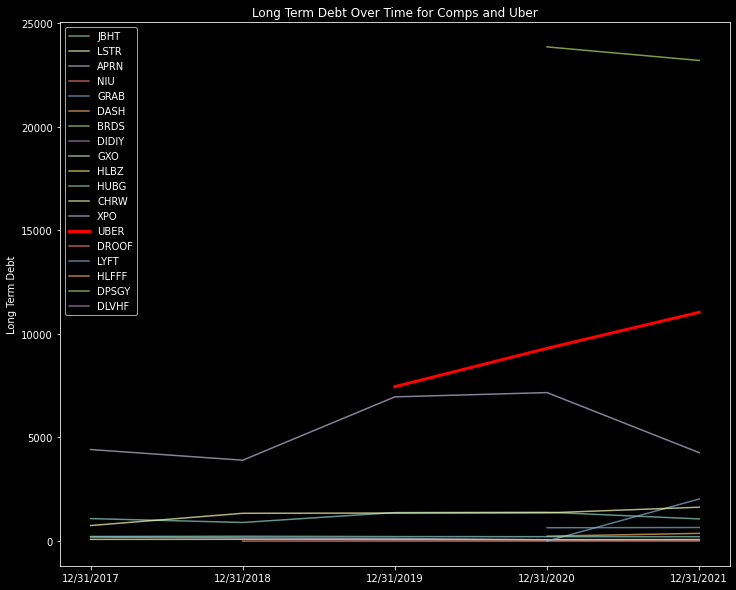

In [11]:
#group by tic and plot dltt over time for each tic; if company is uber plot in red
plt.rcParams['figure.figsize'] = [12, 10]
for tic in comp_financials['tic'].unique():
    df = comp_financials[comp_financials['tic'] == tic]
    if tic == 'UBER':
        plt.plot(df['datadate'], df['dltt'], color='red', linewidth = 3, label=tic)
    else:
        plt.plot(df['datadate'], df['dltt'], label=tic, alpha = 0.7)
plt.title('Long Term Debt Over Time for Comps and Uber')
plt.ylabel('Long Term Debt')
plt.legend(loc='best')
plt.show()


### Assumption II: Constant Debt/Equity Ratio

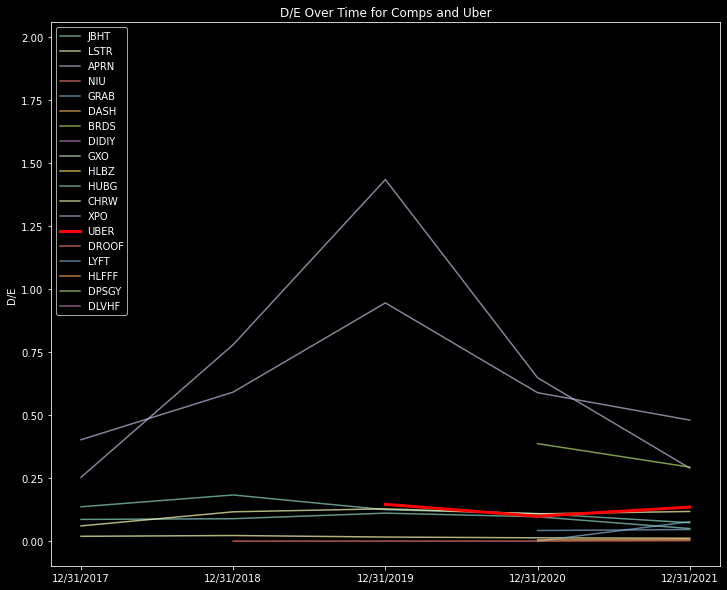

In [12]:
#group by tic and plot dltt over time for each tic; if company is uber plot in red
for tic in comp_financials['tic'].unique():
    df = comp_financials[comp_financials['tic'] == tic]
    if tic == 'UBER':
        plt.plot(df['datadate'], df['dltt'] / (df['csho'] * df['prcc_c']), color='red', linewidth = 3, label=tic)
    else:
        #make opacity of line 0.5
        plt.plot(df['datadate'], df['dltt'] / (df['csho'] * df['prcc_c']), alpha=0.7, label=tic)
plt.rcParams['figure.figsize'] = [12, 10]
plt.title('D/E Over Time for Comps and Uber')
plt.ylabel('D/E')
plt.legend(loc='best')
plt.show()


# This cell needs some work once we ask Sury what to do
Given the plots above of D and D/E over time for both Uber and the Comps, it appears that Assumption I is the most reasonable for delevering the Comp Betas (i.e. constant LTD). To justify the capital structure assumption, we examined the historical finanicals of the corresponding comparables, looking at their measures of Debt over a 5 year period (when available) and their measure of D/E over time. For the comparables without annual financials data available on WRDS, we found information on their 10k statements. 
if the debt was sub-investment grade, at what level did you set the debt beta?  why?  make persuasive, logical arguments--there isn't necessarily "one" right answer here.

## Get the Debt Betas for each of the Comps and Uber


### Step 1: Get the Equity Betas of Comps (2 years, weekly)

#### S&P 500 Data

In [13]:
# download S&P 500 data
sp500 = yf.download('^GSPC', start='2020-10-17', end='2022-10-17', interval='1wk')
sp500 = sp500.dropna()
sp500 = sp500.reset_index()

# get the weekly returns
sp500['weekly_return'] = sp500['Adj Close'].pct_change()
sp500 = sp500.dropna()

[*********************100%***********************]  1 of 1 completed


#### SCL Analysis for all Comps

In [14]:
#function to calculate the weekly returns for a given ticker (2 year time frame)
def beta(ticker, start, end, interval):
    # get data
    data = yf.download(ticker, start=start, end=end, interval=interval)
    data = data.dropna()
    data = data.reset_index()
    
    # calculate weekly returns
    data['weekly_return'] = data['Adj Close'].pct_change()
    
    # drop na
    data = data.dropna()
    
    # merge with sp500 data on date
    data = data.merge(sp500, on='Date', suffixes=('', '_sp500'))

    # run a regression
    X = data['weekly_return_sp500']
    y = data['weekly_return']

    X = sm.add_constant(X)

    model = sm.OLS(y, X).fit()
    
    return model.params[1]

In [15]:
# List of Comps for each Business Segment

mobility = ['LYFT', 'DIDIY', 'GRAB', 'BRDS', 'HLBZ', 'NIU']
delivery = ['DASH', 'DROOF', 'DLVHF', 'HLFFF', 'APRN']
freight = ['CHRW', 'XPO', 'DPSGY', 'GXO', 'JBHT', 'HUBG', 'LSTR']

### Mobility Betas

In [16]:
# Compute the betas for 
mobility_beta = pd.DataFrame()

for ticker in mobility:
    mobility_beta[ticker] = [beta(ticker, '2020-10-17', '2022-10-17', '1wk')]

mobility_beta = mobility_beta.T
mobility_beta.columns = ['Mobility Equity Beta']

mobility_beta

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Mobility Equity Beta
LYFT,1.757576
DIDIY,2.458666
GRAB,1.293262
BRDS,0.775504
HLBZ,1.420304
NIU,1.430427


### Delivery Betas

In [17]:
delivery_beta = pd.DataFrame()

for ticker in delivery:
    delivery_beta[ticker] = [beta(ticker, '2020-10-17', '2022-10-17', '1wk')]

delivery_beta = delivery_beta.T
delivery_beta.columns = ['Delivery Equity Beta']
delivery_beta

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Delivery Equity Beta
DASH,1.732550
DROOF,0.570273
DLVHF,1.411151
HLFFF,0.813275
APRN,1.152158


### Freight Betas

In [18]:
freight_beta = pd.DataFrame()

for ticker in freight:
    freight_beta[ticker] = [beta(ticker, '2020-10-17', '2022-10-17', '1wk')]

freight_beta = freight_beta.T
freight_beta.columns = ['Freight Equity Beta']
freight_beta

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Freight Equity Beta
CHRW,0.803363
XPO,1.405871
DPSGY,1.003579
GXO,1.635069
JBHT,0.978679
HUBG,0.944203
LSTR,0.721047



- then average the cash adj beta for each sector

### Step 2: Unlever the Betas of the Comps (Assumption II) and Cash Adjust Them

<table>
<tr>
<th colspan=4>Penny Stocks (Also < $3.00)</th>
</tr>
<tr>
<th>Segment</th>
<th>Ticker</th>
<th>Company</th>
<th>Price</th>
</tr>
<tr>
<td>Delivery</td>
<td>DROOF</td>
<td>Deliveroo</td>
<td>$1.00</td>
</tr>
<tr>
<td>Delivery</td>
<td>APRN</td>
<td>Blue Apron</td>
<td>$2.53</td>
</tr>
<tr>
<td>Mobility</td>
<td>DIDIY</td>
<td>Didi Global</td>
<td>$1.64</td>
</tr>
<tr>
<td>Mobility</td>
<td>GRAB</td>
<td>Grab Holdings</td>
<td>$2.40</td>
</tr>
<tr>
<td>Mobility</td>
<td>BRDS</td>
<td>Bird Global</td>
<td>$0.37</td>
</tr>
<tr>
<td>Mobility</td>
<td>HLBZ</td>
<td>Helbiz</td>
<td>$0.28</td>
</tr>
<tr>
<td>Mobility</td>
<td>NIU</td>
<td>Niu Technologies</td>
<td>$2.81</td>
</tr>
</table>

In [19]:
# get the relevant information for 2021 for each ticker
comp_2021 = comp_financials[['dltt', 'csho', 'prcc_c', 'che', 'fyear', 'tic', 'conm']].sort_values(by='fyear', ascending=False).drop_duplicates(subset='tic', keep='first')

# Add in the Beta Debt, MV Equity, and D/E Ratio for each Comp as of 2021
comp_2021['beta_debt'] = 0

penny = ['DROOF', 'APRN', 'DIDIY', 'GRAB', 'BRDS', 'HLBZ', 'NIU']
comp_2021.loc[comp_2021['tic'].isin(penny), 'beta_debt'] = 0.3

comp_2021['mv_equity'] = comp_2021['csho'] * comp_2021['prcc_c']
comp_2021['de_ratio'] = comp_2021['dltt'] / comp_2021['mv_equity']

In [20]:
# Compute the Unlevered Beta and Cash Adjusted Beta for each Comp

for index, row in comp_2021.iterrows():
    tic = row['tic']
    if tic in mobility:
        beta_equity = mobility_beta.loc[tic, 'Mobility Equity Beta']
        comp_2021.loc[index, 'segment'] = 'Mobility'
    elif tic in delivery:
        beta_equity = delivery_beta.loc[tic, 'Delivery Equity Beta']
        comp_2021.loc[index, 'segment'] = 'Delivery'
    elif tic in freight:
        beta_equity = freight_beta.loc[tic, 'Freight Equity Beta']
        comp_2021.loc[index, 'segment'] = 'Freight'
    else:
        beta_equity = 0
        #comp_2021.loc[index, 'segment'] = 'Uber'
    comp_2021.loc[index, 'beta_equity'] = beta_equity

comp_2021['beta_unlevered'] = (comp_2021['beta_equity'] / (1 + comp_2021['de_ratio'])) + ((comp_2021['de_ratio'] * comp_2021['beta_debt']) / (1 + comp_2021['de_ratio']))
comp_2021['cash_adj_beta'] = comp_2021['beta_unlevered'] / (1 - ((comp_2021['che']) / (comp_2021['dltt'] + comp_2021['mv_equity'])))

comp_2021.head(20)


,dltt,csho,prcc_c,che,fyear,tic,conm,beta_debt,mv_equity,de_ratio,segment,beta_equity,beta_unlevered,cash_adj_beta
26,18.057,30.515000,5.49,21.143,2021,HLBZ,HELBIZ INC,0.3,167.527350,0.107785,Mobility,1.420304,1.311301,1.479901
18,2.192,76.840000,16.11,204.908,2021,NIU,NIU TECHNOLOGIES -ADR,0.3,1237.892400,0.001771,Mobility,1.430427,1.428429,1.711180
51,23186.000,1232.450000,64.08,3531.000,2021,DPSGY,DHL,0.0,78975.396000,0.293585,Freight,1.003579,0.775812,0.803587
50,175.000,173.710000,19.05,467.200,2021,HLFFF,HELLO FRESH,0.0,3309.175500,0.052883,Delivery,0.813275,0.772426,0.892042
46,655.173,334.724000,42.73,457.325,2021,LYFT,LYFT,0.0,14302.756520,0.045807,Mobility,1.757576,1.680592,1.733595
45,118.100,1707.650646,2.81,1290.900,2021,DROOF,DELIVEROO,0.3,4798.498315,0.024612,Delivery,0.570273,0.563781,0.764510
44,11039.000,1949.316000,41.93,4926.000,2021,UBER,UBER TECHNOLOGIES INC,0.0,81734.819880,0.135059,NaN,0.000000,0.000000,0.000000
41,4266.000,114.737000,77.43,260.000,2021,XPO,XPO LOGISTICS INC,0.0,8884.085910,0.480184,Freight,1.405871,0.949794,0.968952
36,1635.018,129.186000,107.63,257.413,2021,CHRW,C H ROBINSON WORLDWIDE INC,0.0,13904.289180,0.117591,Freight,0.803363,0.718835,0.730943
31,212.395,34.570000,84.24,159.784,2021,HUBG,HUB GROUP INC -CL A,0.0,2912.176800,0.072933,Freight,0.944203,0.880021,0.927448


### Step 3: Get the Average Unlevered/Cash Adjusted Beta for Each Sector

In [21]:
# get the average cash adjusted beta for each segment
average_unlevered = comp_2021.groupby('segment')['cash_adj_beta'].mean()
average_unlevered

segment
Delivery    1.111785
Freight     0.927381
Mobility    1.898363
Name: cash_adj_beta, dtype: float64

### Step 4: Uber Analysis with Comps

##### Segment Multipliers (EV/Sales Sourced from Revenue Multiples by Sector (US) - Stern)
- Delivery: Software (System & Application) (12.84)
- Freight: Transportation (1.52)
- Mobility: Software (System & Application) (12.84)

In [22]:
# Uber Revenue by Segment
uber_revenue = [8632000000, 2132000000, 6953000000]

# Uber Multipliers by Segment
segment_multipliers = [12.84, 1.52, 12.84]

In [23]:
final_df = pd.DataFrame()
final_df['Multiplier'] = segment_multipliers
final_df['Revenue'] = uber_revenue
final_df['Implied Enterprise Value'] = final_df['Multiplier'] * final_df['Revenue']
final_df['Segment Weight'] = final_df["Implied Enterprise Value"] / final_df["Implied Enterprise Value"].sum()
final_df['Unlevered Beta'] = average_unlevered.values
final_df['Weighted Beta Component'] = final_df['Segment Weight'] * final_df['Unlevered Beta']

final_df

,Multiplier,Revenue,Implied Enterprise Value,Segment Weight,Unlevered Beta,Weighted Beta Component
0,12.84,8632000000,1.108349e+11,0.545039,1.111785,0.605967
1,1.52,2132000000,3.240640e+09,0.015936,0.927381,0.014779
2,12.84,6953000000,8.927652e+10,0.439024,1.898363,0.833428


##### Get the Unlevered Beta for Uber

In [24]:
uber_unlevered_beta_cashadj = final_df['Weighted Beta Component'].sum()
uber_unlevered_beta_cashadj

1.4541732798382645

##### Undo Cash Adjustment of Uber's Unlevered Beta

In [25]:
#get just uber row from comp_2021
uber = comp_2021[comp_2021['tic'] == 'UBER']
uber_unlevered_beta = uber_unlevered_beta_cashadj * (1 - ((uber['che']) / (uber['dltt'] + uber['mv_equity'])))
uber_unlevered_beta = uber_unlevered_beta.values[0]
uber_unlevered_beta

1.376961221676288

##### Relever Uber's Beta to Get Final Equity Beta (Assumption II)

In [26]:
levered_beta = uber_unlevered_beta * (1 + uber['de_ratio'])
levered_beta = levered_beta.values[0]
levered_beta

1.5629318391976947